# Thesis Predecessor V3
Now with Uniform Distributions!

In [2]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics
from keras import regularizers
from keras.layers import Dense, Activation, Input, Dropout, BatchNormalization
from keras.models import Sequential
from keras_tqdm import TQDMNotebookCallback as ktqdm
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix

Using TensorFlow backend.


## Reproducibility

1) Definire la struttura dei dati di input
    N interi ordinati
2) Ad ogni predecessore è associato un F(x)
    Calcolare tale F per ogni predecessore
    Dividere i predecessori in Training e Testing
3) Dare in pasto alla rete il training ed il testing
    Il numero risultante, F(x) viene moltiplicato per le dimensioni di Training Set.
    Il numero ottenuto, arrotondato alla cifra successiva, moltiplicato, è il predecessore del numero datoin pasto alla rete.

In [6]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)
tf.set_random_seed(42)

## Creation of uniform distribution
First comes the distribution of predecessors.
Then we create the cumulative of the predecessors.
So we generate a testing set from 1 to size * step.
At last we create an array where every cumulative is cumulative[i] repeated step times

In [7]:
step = 1400
size = 4000
n = step * size
width = np.ceil(np.log2(n)).astype(int)
predecessors = np.arange(0, n, step)
predecessors = np.array([
    (predecessors[i]) for i in range(size)
]).astype(int)
predecessors, predecessors.shape

(array([      0,    1400,    2800, ..., 5595800, 5597200, 5598600]), (4000,))

In [8]:
cumulative_predecessors = np.array([i / size for i in range(size)])
#cumulative_predecessors, cumulative_predecessors.size

In [9]:
testing_distribution = np.array([i for i in range(0, n)]).astype(int)
testing_distribution = np.setdiff1d(testing_distribution, predecessors)
testing_distribution, testing_distribution.size

(array([      1,       2,       3, ..., 5599997, 5599998, 5599999]), 5596000)

In [10]:
testing_cumulatives = np.array([
    (cumulative_predecessors[i]) for i in range(size)
])
testing_cumulatives = np.repeat(testing_cumulatives, step - 1)
testing_cumulatives, testing_cumulatives.size

(array([0.     , 0.     , 0.     , ..., 0.99975, 0.99975, 0.99975]), 5596000)

 ## Bit conversion in digits of predecessors and testing_distribution

In [11]:
#predecessors = np.array([
#    list(np.binary_repr(predecessors[i], width) for i in range(size))
#]).astype(int)
predecessors = np.array([
    list(np.binary_repr(i, width)) for i in np.arange(0, n, step)
]).astype(int)
np.set_printoptions(threshold=100)
predecessors, predecessors.shape

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 1, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 0]]), (4000, 23))

In [12]:
#x = np.array([
 #   list(np.binary_repr(n, width)) for n in np.arange(1, n+1)
#]).astype(int)
#x
testing_distribution_2 = np.array([
    list(np.binary_repr(testing_distribution[i], width)) for i in range((step - 1) * size)
]).astype(int)
testing_distribution_2
#type(testing_distribution[0])

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 1],
       ...,
       [1, 0, 1, ..., 1, 0, 1],
       [1, 0, 1, ..., 1, 1, 0],
       [1, 0, 1, ..., 1, 1, 1]])

## ECDF and ECDF's plot of uniform distribution

In [9]:
def ecdf(sample):
    sample = np.atleast_1d(sample)
    quantiles, counts = np.unique(sample, return_counts=True)
    cumprob = np.cumsum(counts).astype(np.int) / sample.size    
    return quantiles, cumprob

In [10]:
#plt.plot(*ecdf(y))

## Convert uniform of int to uniform of bins

In [11]:
width = np.ceil(np.log2(n)).astype(int)
#x = np.array([
 #   list(np.binary_repr(n, width)) for n in np.arange(1, n+1)
#]).astype(int)
#x

## Create set of training + testing
Join the four sets created, shuffle them and resplit them

In [12]:
training = np.array(list(zip(predecessors, cumulative_predecessors)))
training

array([[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0]),
        0.0],
       [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0]),
        0.00025],
       [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0]),
        0.0005],
       ...,
       [array([1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0]),
        0.99925],
       [array([1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0]),
        0.9995],
       [array([1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0]),
        0.99975]], dtype=object)

In [13]:
testing = np.array(list(zip(testing_distribution_2, testing_cumulatives)))
testing

array([[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1]),
        0.0],
       [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0]),
        0.0],
       [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1]),
        0.0],
       ...,
       [array([1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1]),
        0.99975],
       [array([1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0]),
        0.99975],
       [array([1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1]),
        0.99975]], dtype=object)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(testing_distribution_2, testing_cumulatives, test_size=0.25, random_state=42)

In [15]:
#np.random.shuffle(training)

In [16]:
#np.random.shuffle(testing)

In [17]:
#x_train, y_train = training.T
#x_train, y_train

In [18]:
#x_test, y_test = testing.T
#x_test, y_test

## Network Metrics

In [19]:
def plot_history_graph(history, index, label):
    """Plot the graph for the given history metrics."""
    plt.plot(history.history[index], label='Training %s = %0.6f' % (label, history.history[index][-1]))
    plt.plot(history.history['val_%s'%index] , label='Testing %s = %0.6f' % (label, history.history['val_%s'%index][-1]))
    plt.title('Model %s'%label, fontsize=15)
    plt.ylabel(label)
    plt.xlabel('epoch')
    plt.legend(loc='lower right')
    plt.figure(figsize=(40,20))

In [20]:
def plot_model_roc(training_labels, training_prediction, testing_labels,
                   testing_prediction):
    """Plot roc graph from given labels and predictions."""
    plt.plot(
        *roc_curve(training_labels, training_prediction)[:2],
        label='Training ROC curve (area = %0.6f)' % roc_auc_score(
            training_labels, training_prediction))
    plt.plot(
        *roc_curve(testing_labels, testing_prediction)[:2],
        label='Testing ROC curve (area = %0.6f)' % roc_auc_score(
            testing_labels, testing_prediction))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC)', fontsize=15)
    plt.legend(loc="lower right")

In [21]:
def plot_model_prc(training_labels, training_prediction, testing_labels,
                   testing_prediction):
    """Plot Precision-Recall curve"""
    plt.plot(
        *precision_recall_curve(training_labels, training_predction)[:2],
        label='Training average precision = %0.6f' % average_precision_score(
            training_labels, training_prediction))
    plt.plot(
        *precision_recall_curve(testing_labels, testing_prediction)[:2],
        label='Testing average precision = %0.6f' % average_precision_score(
            testing_labels, testing_prediction))
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower left")
    plt.title('2-class Precision-Recall curve (PRC)', fontsize=15)

## Definition of plotting functions

In [22]:
import itertools


def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, roation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.6f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [23]:
def plot_summary_statistics(model, history, training, testing, training_labels, testing_labels):
    # We print a summary of the progress
    training_prediction = model.predict_proba(training)
    testing_prediction = model.predict_proba(testing)

    plt.figure(figsize=(20, 10))
    plt.subplot(2, 4, 1)
    plot_history_graph(history, 'acc', 'accuracy')
    plt.subplot(2, 4, 2)
    plot_history_graph(history, 'loss', 'loss')
    plt.subplot(2, 4, 3)
    plot_model_roc(training_labels, training_prediction, testing_labels,
                   testing_prediction)
    plt.subplot(2, 4, 4)
    plot_model_prc(training_labels, training_prediction, testing_labels,
                   testing_prediction)
    plt.subplot(2, 4, 5)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(training_labels, training_prediction.round())

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(
        cnf_matrix,
        classes=["Negatives", "Positives"],
        title='Training Confusion matrix, without normalization')
    plt.subplot(2, 4, 6)
    plot_confusion_matrix(
        cnf_matrix,
        classes=["Negatives", "Positives"],
        normalize=True,
        title='Training Confusion matrix normalized')
    plt.subplot(2, 4, 7)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(testing_labels, testing_prediction.round())

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(
        cnf_matrix,
        classes=["Negatives", "Positives"],
        title='Testing Confusion matrix, without normalization')
    plt.subplot(2, 4, 8)
    plot_confusion_matrix(
        cnf_matrix,
        classes=["Negatives", "Positives"],
        normalize=True,
        title='Testing Confusion matrix normalized')
    plt.show()

## Define function to build the model

In [24]:
def build_model(neurons):
    """ Return keras network model """
    model = Sequential()
    model.add(Dense(neurons * 2, input_dim=neurons, name="Input_dense_layer"))
    model.add(Activation("sigmoid", name="Input_Sigmoid"))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    #model.add(Dense(8, name="Hidden_dense_layer_1"))
    #model.add(Activation("sigmoid", name="Hidden_Sigmoid_1"))
    #model.add(Dropout(0.5))
    #model.add(BatchNormalization())
    #model.add(Dense(5, name="Hidden_dense_layer_2"))
    #model.add(Activation("sigmoid", name="Hidden_Sigmoid_2"))
    #model.add(Dropout(0.5))
    #model.add(BatchNormalization())
    model.add(Dense(1, name="Output_dense_layer"))
    model.add(Activation("sigmoid", name="Output_Sigmoid"))
    model.add(BatchNormalization())
    model.compile(
        loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])

    return model

## Construction of the model

In [25]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)
tf.set_random_seed(42)

model = build_model(width)
model.summary()
predecessors.shape

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_dense_layer (Dense)    (None, 46)                1104      
_________________________________________________________________
Input_Sigmoid (Activation)   (None, 46)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 46)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 46)                184       
_________________________________________________________________
Output_dense_layer (Dense)   (None, 1)                 47        
_________________________________________________________________
Output_Sigmoid (Activation)  (None, 1)                 0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1)                 4         
Total para

(4000, 23)

In [26]:
history = model.fit(
    x_train,
    y_train,
    epochs=30,
    shuffle=True,
    batch_size=2048,
    verbose=0,
    callbacks=[ktqdm(metric_format="{name}: {value:e}")],
    validation_data=(x_test, y_test)
)

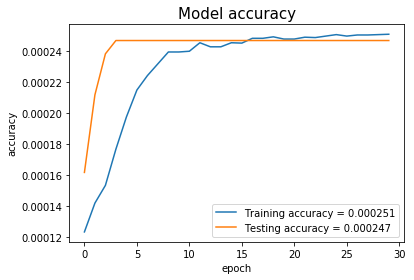

<Figure size 2880x1440 with 0 Axes>

In [27]:
plot_history_graph(history, 'acc', 'accuracy')

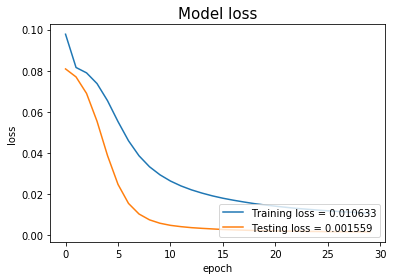

<Figure size 2880x1440 with 0 Axes>

In [28]:
plot_history_graph(history, 'loss', 'loss')

In [29]:
#roc_auc_score(y_train, x_train)

In [30]:
 #model.predict(np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]])) * n 
    #np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]).shape